## ⚙️ Import Libraries

##To connect to Google Drive

In [ ]:
from google.colab import drive

drive.mount('/gdrive')
%cd /gdrive/My Drive/[2024-2025] AN2DL/Homework 1

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive/My Drive/PROVE ANN


In [ ]:
!pip install keras_cv

In [ ]:
# Set seed for reproducibility
seed = 42

# Import necessary libraries
import os

# Set environment variables before importing modules
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd() + '/configs/'

# Suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

# Import necessary modules
import logging
import random
import numpy as np

# Set seeds for random number generators in NumPy and Python
np.random.seed(seed)
random.seed(seed)

# Import TensorFlow and Keras
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl

# Set seed for TensorFlow
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

# Reduce TensorFlow verbosity
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# Print TensorFlow version
print(tf.__version__)

# Import other libraries
import requests
from io import BytesIO
import cv2
from PIL import Image
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.utils import compute_class_weight
import seaborn as sns
import keras_cv.layers as kcvl

# Configure plot display settings
sns.set(font_scale=1.4)
sns.set_style('white')
plt.rc('font', size=14)
%matplotlib inline

2.17.1


In [ ]:
import albumentations as A
import numpy as np
import matplotlib.pyplot as plt
import random

In [ ]:
pip install --upgrade albumentations

## ⏳ Load Data

## For Kaggle

In [ ]:
data = np.load('/kaggle/input/initial-dataset/training_set.npz')
X = data['images']
y = data['labels']

FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/input/initial-dataset/training_set.npz'

## For Colab

In [ ]:
data = np.load('training_set.npz')
X = data['images']
y = data['labels']

In [ ]:
X = X[:11958]
y = y[:11958]
classes = np.array(np.unique(y))
class_names = ['Basophil','Eosinophil','Erythroblast','Immature granulocytes','Lymphocyte','Monocyte','Neutrophil','Platelet']
print(classes)
print(class_names)

[0 1 2 3 4 5 6 7]
['Basophil', 'Eosinophil', 'Erythroblast', 'Immature granulocytes', 'Lymphocyte', 'Monocyte', 'Neutrophil', 'Platelet']


In [ ]:
# Make sure that y is a flat array of integer values.
y_flat = np.array(y).flatten()

# Get the unique classes in y_flat.
classes = np.unique(y_flat)

# Calculation of class weights.
class_weights = compute_class_weight('balanced', classes=classes, y=y_flat)

# Conversion of class weights into a dictionary.
class_weights_dict = dict(enumerate(class_weights))

# Printing class weights.
print(class_weights_dict)

{0: 1.7544014084507042, 1: 0.6853507565337001, 2: 1.3776497695852534, 3: 0.7377838104639685, 4: 1.762676886792453, 5: 1.505287009063444, 6: 0.6415236051502146, 7: 0.9097687157638467}


## 🔎 Inspect Data

In [ ]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=seed, test_size=0.25, stratify=y)

# Split test set into validation and test sets with stratification
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, random_state=seed, test_size=0.5, stratify=y_test)

# Convert targets to categorical
y_train = tfk.utils.to_categorical(y_train, num_classes=len(class_names))
y_val = tfk.utils.to_categorical(y_val, num_classes=len(class_names))
y_test = tfk.utils.to_categorical(y_test, num_classes=len(class_names))

# Print shapes of the datasets
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

X_train shape: (8968, 96, 96, 3), y_train shape: (8968, 8)
X_val shape: (1495, 96, 96, 3), y_val shape: (1495, 8)
X_test shape: (1495, 96, 96, 3), y_test shape: (1495, 8)


In [ ]:
# Define a transformation pipeline.
transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.Rotate(limit=45, p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.HueSaturationValue(hue_shift_limit=40, sat_shift_limit=30, val_shift_limit=20, p=0.3),
    A.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1, p=0.3),
    A.Defocus(radius=(1,3), alias_blur=(0.5, 0.5), p=0.3),
    A.CLAHE(clip_limit=(3, 3), tile_grid_size=(8, 8), p=0.3),
    A.Downscale(scale_range=(0.5, 0.75), interpolation_pair={'downscale': cv2.INTER_NEAREST, 'upscale': cv2.INTER_LINEAR}, p=0.3),
    A.GaussNoise(p=0.2),
    A.RandomCrop(height=70,width=70, p=0.3),
    A.RandomScale(scale_limit=0.6, p=0.2),
    A.Resize(96, 96)  # Garantisce che tutte le immagini siano 96x96
])

In [ ]:
# Apply transformations to the entire training dataset.
X_augmented = []

for img in X_train:
    augmented = transform(image=img)  #pass the image as a named argument
    X_augmented.append(augmented["image"])

# Convert the transformed dataset into a NumPy array.
X_augmented = np.array(X_augmented)

In [ ]:
print(f"X_train shape: {X_train.shape}, X_augmented shape: {X_augmented.shape}")

X_train shape: (8968, 96, 96, 3), X_augmented shape: (8968, 96, 96, 3)


## 🛠️ General settings



## 🛠️ Transfer Learning on EffNetV2



In [ ]:
from keras.applications.efficientnet_v2 import EfficientNetV2M

In [ ]:
from tensorflow.keras.layers import LayerNormalization, GroupNormalization

In [ ]:
# Initialise EfficientNetV2M model with pretrained weights, for transfer learning
eff = tfk.applications.EfficientNetV2M(
    input_shape=(96, 96, 3),
    include_top=False,
    weights='imagenet',
    include_preprocessing=True,
)
eff.trainable = False

214201816/214201816 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [ ]:
# Optimizer with exponential decay
optimizer = tf.keras.optimizers.Lion(1e-4)

# ReduceLROnPlateau for fine adjustments
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_accuracy',  # Monitor validation accuracy
    factor=0.5,              # Halve the learning rate
    patience=5,             # Wait 10 epochs for no improvement
    min_lr=1e-6,             # Minimum learning rate
    verbose=1                # Log learning rate changes
)

In [ ]:
#DEF OF CUSTOM MODEL
def build_eff_aug(input_shape=(96, 96, 3)):

    """Build a ConvNeXtLarge-based CNN with image augmentation"""

    # Input layer
    inputs = tfk.Input(shape=(96, 96, 3), name='input_layer')

    # EfficientNet base model
    x = eff(inputs)

    # Inception Block
    def inception_block(inputs):
        tower_1 = tfkl.Conv2D(64, (1, 1), activation='relu')(inputs)
        tower_1 = tfkl.Conv2D(64, (3, 3), padding='same', activation='relu')(tower_1)

        tower_2 = tfkl.Conv2D(64, (1, 1), activation='relu')(inputs)
        tower_2 = tfkl.Conv2D(64, (5, 5), padding='same', activation='relu')(tower_2)

        tower_3 = tfkl.MaxPooling2D((3, 3), strides=(1, 1), padding='same')(inputs)
        tower_3 = tfkl.Conv2D(64, (1, 1), activation='relu')(tower_3)

        output = tfkl.concatenate([tower_1, tower_2, tower_3], axis=-1)
        return output

    x = inception_block(x)

    # Flatten and fully connected layers with Group Normalization
    x = tfkl.Flatten()(x)
    x = tfkl.Dropout(0.5)(x)
    x = GroupNormalization(groups=8, axis=-1)(x)
    x = tfkl.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.L2(1e-5), name='dense_128')(x)
    x = tfkl.Dropout(0.1)(x)

    # Output layer
    outputs = tfkl.Dense(y_train.shape[-1], activation='softmax', name='dense')(x)

    # Final model
    model = tfk.Model(inputs=inputs, outputs=outputs, name='model')

    # Compile the model
    model.compile(
        loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
        optimizer=optimizer,
        metrics=['accuracy']
    )
    # Return the model
    return model

In [ ]:
# Build an EffNetV2M based custom  model for transfer learning
tl_model_eff = build_eff_aug()

# Train the model
tl_history_eff = tl_model_eff.fit(
    x=X_augmented,
    y=y_train,
    batch_size=64,
    epochs=30,
    validation_data=(X_val, y_val),
    class_weight = class_weights_dict,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_accuracy', mode='max', patience=20, restore_best_weights=True
        ),
        reduce_lr  # Add dynamic learning rate adjustment
    ]
).history

# Calculate and print the best validation accuracy achieved
final_val_accuracy = round(max(tl_history_eff['val_accuracy']) * 100, 2)
print(f'Final validation accuracy: {final_val_accuracy}%')

# Save the trained model to a file, including final accuracy in the filename
model_filename = 'CNN_' + str(final_val_accuracy) + '.keras'
tl_model_eff.save(model_filename)

# Save weights of the Transfer Learning model
tl_model_eff.save_weights('tl.weights.h5')

# Free memory by deleting the model instance
del tl_model_eff

Epoch 1/30
141/141 ━━━━━━━━━━━━━━━━━━━━ 151s 526ms/step - accuracy: 0.2594 - loss: 2.1014 - val_accuracy: 0.7324 - val_loss: 1.1256 - learning_rate: 1.0000e-04
Epoch 2/30
141/141 ━━━━━━━━━━━━━━━━━━━━ 38s 86ms/step - accuracy: 0.5693 - loss: 1.4186 - val_accuracy: 0.8214 - val_loss: 1.0276 - learning_rate: 1.0000e-04
Epoch 3/30
141/141 ━━━━━━━━━━━━━━━━━━━━ 11s 77ms/step - accuracy: 0.6628 - loss: 1.2190 - val_accuracy: 0.8682 - val_loss: 0.9262 - learning_rate: 1.0000e-04
Epoch 4/30
141/141 ━━━━━━━━━━━━━━━━━━━━ 20s 74ms/step - accuracy: 0.7225 - loss: 1.1126 - val_accuracy: 0.8649 - val_loss: 0.9459 - learning_rate: 1.0000e-04
Epoch 5/30
141/141 ━━━━━━━━━━━━━━━━━━━━ 22s 87ms/step - accuracy: 0.7376 - loss: 1.0772 - val_accuracy: 0.8876 - val_loss: 0.9025 - learning_rate: 1.0000e-04
Epoch 6/30
141/141 ━━━━━━━━━━━━━━━━━━━━ 12s 86ms/step - accuracy: 0.7612 - loss: 1.0215 - val_accuracy: 0.8883 - val_loss: 0.8576 - learning_rate: 1.0000e-04
Epoch 7/30
141/141 ━━━━━━━━━━━━━━━━━━━━ 20s 85ms/s

## 🛠️ Transfer Learning on MobileNetV3Small



In [ ]:
# Initialise MobileNetV3Small model with pretrained weights, for transfer learning
mobile = tfk.applications.MobileNetV3Small(
    input_shape=(96, 96, 3),
    include_top=False,
    weights='imagenet',
    include_preprocessing=True,
)
mobile.trainable = False

4334752/4334752 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# Optimizer with exponential decay
optimizer = tf.keras.optimizers.Lion(1e-4)

# ReduceLROnPlateau for fine adjustments
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_accuracy',  # Monitor validation accuracy
    factor=0.5,              # Halve the learning rate
    patience=5,             # Wait 10 epochs for no improvement
    min_lr=1e-6,             # Minimum learning rate
    verbose=1                # Log learning rate changes
)

In [ ]:
#DEF OF CUSTOM MODEL
def build_mobile_aug(input_shape=(96, 96, 3)):

    """Build a ConvNeXtLarge-based CNN with image augmentation"""

    # Input layer
    inputs = tfk.Input(shape=(96, 96, 3), name='input_layer')

    # MobileNet base model
    x = mobile(inputs)

    # Inception Block
    def inception_block(inputs):
        tower_1 = tfkl.Conv2D(64, (1, 1), activation='relu')(inputs)
        tower_1 = tfkl.Conv2D(64, (3, 3), padding='same', activation='relu')(tower_1)

        tower_2 = tfkl.Conv2D(64, (1, 1), activation='relu')(inputs)
        tower_2 = tfkl.Conv2D(64, (5, 5), padding='same', activation='relu')(tower_2)

        tower_3 = tfkl.MaxPooling2D((3, 3), strides=(1, 1), padding='same')(inputs)
        tower_3 = tfkl.Conv2D(64, (1, 1), activation='relu')(tower_3)

        output = tfkl.concatenate([tower_1, tower_2, tower_3], axis=-1)
        return output

    x = inception_block(x)

    # Flatten and fully connected layers with Group Normalization
    x = tfkl.Flatten()(x)
    x = tfkl.Dropout(0.5)(x)
    x = GroupNormalization(groups=8, axis=-1)(x)
    x = tfkl.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.L2(1e-5), name='dense_128')(x)
    x = tfkl.Dropout(0.1)(x)

    # Output layer
    outputs = tfkl.Dense(y_train.shape[-1], activation='softmax', name='dense')(x)

    # Final model
    model = tfk.Model(inputs=inputs, outputs=outputs, name='model')

    # Compile the model
    model.compile(
        loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
        optimizer=optimizer,
        metrics=['accuracy']
    )
    # Return the model
    return model

In [ ]:
# Build an MobileNet based custom  model for transfer learning
tl_model_mobile = build_mobile_aug()

# Train the model
tl_history_mobile = tl_model_mobile.fit(
    x=X_augmented,
    y=y_train,
    batch_size=64,
    epochs=30,
    validation_data=(X_val, y_val),
    class_weight = class_weights_dict,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_accuracy', mode='max', patience=20, restore_best_weights=True
        ),
        reduce_lr  # Add dynamic learning rate adjustment
    ]
).history

# Calculate and print the best validation accuracy achieved
final_val_accuracy = round(max(tl_history_mobile['val_accuracy']) * 100, 2)
print(f'Final validation accuracy: {final_val_accuracy}%')

# Save the trained model to a file, including final accuracy in the filename
model_filename = 'CNN_' + str(final_val_accuracy) + '.keras'
tl_model_mobile.save(model_filename)

# Save weights of the Transfer Learning model
tl_model_mobile.save_weights('tl.weights.h5')

# Free memory by deleting the model instance
del tl_model_mobile

Epoch 1/30
141/141 ━━━━━━━━━━━━━━━━━━━━ 32s 132ms/step - accuracy: 0.3181 - loss: 2.0387 - val_accuracy: 0.7518 - val_loss: 1.0927 - learning_rate: 1.0000e-04
Epoch 2/30
141/141 ━━━━━━━━━━━━━━━━━━━━ 16s 9ms/step - accuracy: 0.6771 - loss: 1.1935 - val_accuracy: 0.8221 - val_loss: 1.0339 - learning_rate: 1.0000e-04
Epoch 3/30
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7733 - loss: 1.0059 - val_accuracy: 0.8763 - val_loss: 0.9038 - learning_rate: 1.0000e-04
Epoch 4/30
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.8254 - loss: 0.9041 - val_accuracy: 0.8870 - val_loss: 0.8777 - learning_rate: 1.0000e-04
Epoch 5/30
141/141 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.8585 - loss: 0.8293 - val_accuracy: 0.8997 - val_loss: 0.8825 - learning_rate: 1.0000e-04
Epoch 6/30
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8869 - loss: 0.7617 - val_accuracy: 0.9030 - val_loss: 0.8420 - learning_rate: 1.0000e-04
Epoch 7/30
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accur

## 🛠️ Transfer Learning on EfficientNetB0

In [ ]:
from tensorflow.keras.applications import EfficientNetB0


In [ ]:
# Initialise EfficientNetB0 model with pretrained weights, for transfer learning
effb0 = tfk.applications.EfficientNetB0(
    input_shape=(96, 96, 3),
    include_top=False,
    weights='imagenet',
)
effb0.trainable = False

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# Optimizer with exponential decay
optimizer = tf.keras.optimizers.Lion(1e-4)

# ReduceLROnPlateau for fine adjustments
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_accuracy',  # Monitor validation accuracy
    factor=0.5,              # Halve the learning rate
    patience=5,             # Wait 10 epochs for no improvement
    min_lr=1e-6,             # Minimum learning rate
    verbose=1                # Log learning rate changes
)

In [ ]:
#DEF OF CUSTOM MODEL
def build_effb0_aug(input_shape=(96, 96, 3)):

    """Build a ConvNeXtLarge-based CNN with image augmentation"""

    # Input layer
    inputs = tfk.Input(shape=(96, 96, 3), name='input_layer')

    # effb0 base model
    x = effb0(inputs)

    # Inception Block
    def inception_block(inputs):
        tower_1 = tfkl.Conv2D(64, (1, 1), activation='relu')(inputs)
        tower_1 = tfkl.Conv2D(64, (3, 3), padding='same', activation='relu')(tower_1)

        tower_2 = tfkl.Conv2D(64, (1, 1), activation='relu')(inputs)
        tower_2 = tfkl.Conv2D(64, (5, 5), padding='same', activation='relu')(tower_2)

        tower_3 = tfkl.MaxPooling2D((3, 3), strides=(1, 1), padding='same')(inputs)
        tower_3 = tfkl.Conv2D(64, (1, 1), activation='relu')(tower_3)

        output = tfkl.concatenate([tower_1, tower_2, tower_3], axis=-1)
        return output

    x = inception_block(x)

    # Flatten and fully connected layers with Group Normalization
    x = tfkl.Flatten()(x)
    x = tfkl.Dropout(0.5)(x)
    x = GroupNormalization(groups=8, axis=-1)(x)
    x = tfkl.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.L2(1e-5), name='dense_128')(x)
    x = tfkl.Dropout(0.1)(x)

    # Output layer
    outputs = tfkl.Dense(y_train.shape[-1], activation='softmax', name='dense')(x)

    # Final model
    model = tfk.Model(inputs=inputs, outputs=outputs, name='model')

    # Compile the model
    model.compile(
        loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
        optimizer=optimizer,
        metrics=['accuracy']
    )
    # Return the model
    return model

In [ ]:
# Build an EffNetB0 based custom  model for transfer learning
tl_model_effb0 = build_effb0_aug()

# Train the model
tl_history_effb0 = tl_model_effb0.fit(
    x=X_augmented,
    y=y_train,
    batch_size=64,
    epochs=30,
    validation_data=(X_val, y_val),
    class_weight = class_weights_dict,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_accuracy', mode='max', patience=20, restore_best_weights=True
        ),
        reduce_lr  # Add dynamic learning rate adjustment
    ]
).history

# Calculate and print the best validation accuracy achieved
final_val_accuracy = round(max(tl_history_effb0['val_accuracy']) * 100, 2)
print(f'Final validation accuracy: {final_val_accuracy}%')

# Save the trained model to a file, including final accuracy in the filename
model_filename = 'CNN_' + str(final_val_accuracy) + '.keras'
tl_model_effb0.save(model_filename)

# Save weights of the Transfer Learning model
tl_model_effb0.save_weights('tl.weights.h5')

# Free memory by deleting the model instance
del tl_model_effb0

Epoch 1/30
141/141 ━━━━━━━━━━━━━━━━━━━━ 53s 191ms/step - accuracy: 0.3276 - loss: 1.9503 - val_accuracy: 0.7719 - val_loss: 1.0765 - learning_rate: 1.0000e-04
Epoch 2/30
141/141 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.6707 - loss: 1.1939 - val_accuracy: 0.8355 - val_loss: 0.9840 - learning_rate: 1.0000e-04
Epoch 3/30
141/141 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.7600 - loss: 1.0237 - val_accuracy: 0.8602 - val_loss: 0.9527 - learning_rate: 1.0000e-04
Epoch 4/30
141/141 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.8052 - loss: 0.9321 - val_accuracy: 0.8602 - val_loss: 0.9255 - learning_rate: 1.0000e-04
Epoch 5/30
141/141 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - accuracy: 0.8319 - loss: 0.8699 - val_accuracy: 0.8769 - val_loss: 0.8818 - learning_rate: 1.0000e-04
Epoch 6/30
141/141 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - accuracy: 0.8618 - loss: 0.8290 - val_accuracy: 0.8883 - val_loss: 0.8758 - learning_rate: 1.0000e-04
Epoch 7/30
141/141 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - a

## 🛠️ Transfer Learning on VGG16

In [ ]:
from tensorflow.keras.applications import VGG16


In [ ]:
# Initialise VGG16 model with pretrained weights, for transfer learning
VGG = tfk.applications.VGG16(
    input_shape=(96, 96, 3),
    include_top=False,
    weights='imagenet',
)
VGG.trainable = False

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# Optimizer with exponential decay
optimizer = tf.keras.optimizers.Lion(1e-4)

# ReduceLROnPlateau for fine adjustments
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_accuracy',  # Monitor validation accuracy
    factor=0.5,              # Halve the learning rate
    patience=5,             # Wait 10 epochs for no improvement
    min_lr=1e-6,             # Minimum learning rate
    verbose=1                # Log learning rate changes
)

In [ ]:
#DEF OF CUSTOM MODEL
def build_VGG_aug(input_shape=(96, 96, 3)):

    """Build a ConvNeXtLarge-based CNN with image augmentation"""

    # Input layer
    inputs = tfk.Input(shape=(96, 96, 3), name='input_layer')

    # VGG base model
    x = VGG(inputs)

    # Inception Block
    def inception_block(inputs):
        tower_1 = tfkl.Conv2D(64, (1, 1), activation='relu')(inputs)
        tower_1 = tfkl.Conv2D(64, (3, 3), padding='same', activation='relu')(tower_1)

        tower_2 = tfkl.Conv2D(64, (1, 1), activation='relu')(inputs)
        tower_2 = tfkl.Conv2D(64, (5, 5), padding='same', activation='relu')(tower_2)

        tower_3 = tfkl.MaxPooling2D((3, 3), strides=(1, 1), padding='same')(inputs)
        tower_3 = tfkl.Conv2D(64, (1, 1), activation='relu')(tower_3)

        output = tfkl.concatenate([tower_1, tower_2, tower_3], axis=-1)
        return output

    x = inception_block(x)

    # Flatten and fully connected layers with Group Normalization
    x = tfkl.Flatten()(x)
    x = tfkl.Dropout(0.5)(x)
    x = GroupNormalization(groups=8, axis=-1)(x)
    x = tfkl.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.L2(1e-5), name='dense_128')(x)
    x = tfkl.Dropout(0.1)(x)
    # Output layer
    outputs = tfkl.Dense(y_train.shape[-1], activation='softmax', name='dense')(x)

    # Final model
    model = tfk.Model(inputs=inputs, outputs=outputs, name='model')

    # Compile the model
    model.compile(
        loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
        optimizer=optimizer,
        metrics=['accuracy']
    )
    # Return the model
    return model

In [ ]:
# Build an VGG16 based custom  model for transfer learning
tl_model_VGG = build_VGG_aug()

# Train the model
tl_history_VGG = tl_model_VGG.fit(
    x=X_augmented,
    y=y_train,
    batch_size=64,
    epochs=30,
    validation_data=(X_val, y_val),
    class_weight = class_weights_dict,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_accuracy', mode='max', patience=20, restore_best_weights=True
        ),
        reduce_lr  # Add dynamic learning rate adjustment
    ]
).history

# Calculate and print the best validation accuracy achieved
final_val_accuracy = round(max(tl_history_VGG['val_accuracy']) * 100, 2)
print(f'Final validation accuracy: {final_val_accuracy}%')

# Save the trained model to a file, including final accuracy in the filename
model_filename = 'CNN_' + str(final_val_accuracy) + '.keras'
tl_model_VGG.save(model_filename)

# Save weights of the Transfer Learning model
tl_model_VGG.save_weights('tl.weights.h5')

# Free memory by deleting the model instance
del tl_model_VGG

Epoch 1/30
141/141 ━━━━━━━━━━━━━━━━━━━━ 33s 151ms/step - accuracy: 0.2468 - loss: 2.1874 - val_accuracy: 0.6341 - val_loss: 1.2980 - learning_rate: 1.0000e-04
Epoch 2/30
141/141 ━━━━━━━━━━━━━━━━━━━━ 18s 55ms/step - accuracy: 0.5654 - loss: 1.3757 - val_accuracy: 0.7431 - val_loss: 1.1522 - learning_rate: 1.0000e-04
Epoch 3/30
141/141 ━━━━━━━━━━━━━━━━━━━━ 8s 54ms/step - accuracy: 0.6721 - loss: 1.1885 - val_accuracy: 0.8000 - val_loss: 1.0573 - learning_rate: 1.0000e-04
Epoch 4/30
141/141 ━━━━━━━━━━━━━━━━━━━━ 11s 57ms/step - accuracy: 0.7358 - loss: 1.0620 - val_accuracy: 0.8080 - val_loss: 1.0099 - learning_rate: 1.0000e-04
Epoch 5/30
141/141 ━━━━━━━━━━━━━━━━━━━━ 8s 55ms/step - accuracy: 0.7836 - loss: 0.9604 - val_accuracy: 0.8274 - val_loss: 0.9820 - learning_rate: 1.0000e-04
Epoch 6/30
141/141 ━━━━━━━━━━━━━━━━━━━━ 8s 57ms/step - accuracy: 0.8270 - loss: 0.8841 - val_accuracy: 0.8268 - val_loss: 0.9722 - learning_rate: 1.0000e-04
Epoch 7/30
141/141 ━━━━━━━━━━━━━━━━━━━━ 8s 56ms/step -

## 🛠️ Transfer Learning on ConvNeXtBase

In [ ]:
from tensorflow.keras.applications import ConvNeXtBase

In [ ]:
# Initialise ConvNeXtBase model with pretrained weights, for transfer learning
ConvNext = tfk.applications.ConvNeXtBase(
    input_shape=(96, 96, 3),
    include_top=False,
    weights='imagenet',
)
ConvNext.trainable = False

350926856/350926856 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [ ]:
# Optimizer with exponential decay
optimizer = tf.keras.optimizers.Lion(1e-4)

# ReduceLROnPlateau for fine adjustments
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_accuracy',  # Monitor validation accuracy
    factor=0.5,              # Halve the learning rate
    patience=5,             # Wait 10 epochs for no improvement
    min_lr=1e-6,             # Minimum learning rate
    verbose=1                # Log learning rate changes
)

In [ ]:
#DEF OF CUSTOM MODEL
def build_ConvNext_aug(input_shape=(96, 96, 3)):

    """Build a ConvNeXtLarge-based CNN with image augmentation"""

    # Input layer
    inputs = tfk.Input(shape=(96, 96, 3), name='input_layer')

    # ConvNextBase base model
    x = ConvNext(inputs)

    # Inception Block
    def inception_block(inputs):
        tower_1 = tfkl.Conv2D(64, (1, 1), activation='relu')(inputs)
        tower_1 = tfkl.Conv2D(64, (3, 3), padding='same', activation='relu')(tower_1)

        tower_2 = tfkl.Conv2D(64, (1, 1), activation='relu')(inputs)
        tower_2 = tfkl.Conv2D(64, (5, 5), padding='same', activation='relu')(tower_2)

        tower_3 = tfkl.MaxPooling2D((3, 3), strides=(1, 1), padding='same')(inputs)
        tower_3 = tfkl.Conv2D(64, (1, 1), activation='relu')(tower_3)

        output = tfkl.concatenate([tower_1, tower_2, tower_3], axis=-1)
        return output

    x = inception_block(x)

    # Flatten and fully connected layers with Group Normalization
    x = tfkl.Flatten()(x)
    x = tfkl.Dropout(0.5)(x)
    x = GroupNormalization(groups=8, axis=-1)(x)
    x = tfkl.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.L2(1e-5), name='dense_128')(x)
    x = tfkl.Dropout(0.1)(x)
    # Output layer
    outputs = tfkl.Dense(y_train.shape[-1], activation='softmax', name='dense')(x)

    # Final model
    model = tfk.Model(inputs=inputs, outputs=outputs, name='model')

    # Compile the model
    model.compile(
        loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
        optimizer=optimizer,
        metrics=['accuracy']
    )
    # Return the model
    return model

In [ ]:
# Build an ConvNexBase based custom  model for transfer learning
tl_model_ConvNext = build_ConvNext_aug()

# Train the model
tl_history_ConvNext = tl_model_ConvNext.fit(
    x=X_augmented,
    y=y_train,
    batch_size=64,
    epochs=30,
    validation_data=(X_val, y_val),
    class_weight = class_weights_dict,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_accuracy', mode='max', patience=20, restore_best_weights=True
        ),
        reduce_lr  # Add dynamic learning rate adjustment
    ]
).history

# Calculate and print the best validation accuracy achieved
final_val_accuracy = round(max(tl_history_ConvNext['val_accuracy']) * 100, 2)
print(f'Final validation accuracy: {final_val_accuracy}%')

# Save the trained model to a file, including final accuracy in the filename
model_filename = 'CNN_' + str(final_val_accuracy) + '.keras'
tl_model_ConvNext.save(model_filename)

# Save weights of the Transfer Learning model
tl_model_ConvNext.save_weights('tl.weights.h5')

# Free memory by deleting the model instance
del tl_model_ConvNext

Epoch 1/30
141/141 ━━━━━━━━━━━━━━━━━━━━ 74s 342ms/step - accuracy: 0.3624 - loss: 1.8931 - val_accuracy: 0.8515 - val_loss: 0.9653 - learning_rate: 1.0000e-04
Epoch 2/30
141/141 ━━━━━━━━━━━━━━━━━━━━ 46s 145ms/step - accuracy: 0.7740 - loss: 1.0208 - val_accuracy: 0.9110 - val_loss: 0.8304 - learning_rate: 1.0000e-04
Epoch 3/30
141/141 ━━━━━━━━━━━━━━━━━━━━ 43s 162ms/step - accuracy: 0.8551 - loss: 0.8407 - val_accuracy: 0.9284 - val_loss: 0.7680 - learning_rate: 1.0000e-04
Epoch 4/30
141/141 ━━━━━━━━━━━━━━━━━━━━ 21s 150ms/step - accuracy: 0.9081 - loss: 0.7339 - val_accuracy: 0.9472 - val_loss: 0.7337 - learning_rate: 1.0000e-04
Epoch 5/30
141/141 ━━━━━━━━━━━━━━━━━━━━ 40s 145ms/step - accuracy: 0.9279 - loss: 0.6735 - val_accuracy: 0.9411 - val_loss: 0.7259 - learning_rate: 1.0000e-04
Epoch 6/30
141/141 ━━━━━━━━━━━━━━━━━━━━ 41s 146ms/step - accuracy: 0.9480 - loss: 0.6295 - val_accuracy: 0.9472 - val_loss: 0.7090 - learning_rate: 1.0000e-04
Epoch 7/30
141/141 ━━━━━━━━━━━━━━━━━━━━ 44s 16

## PLOT MODELLI

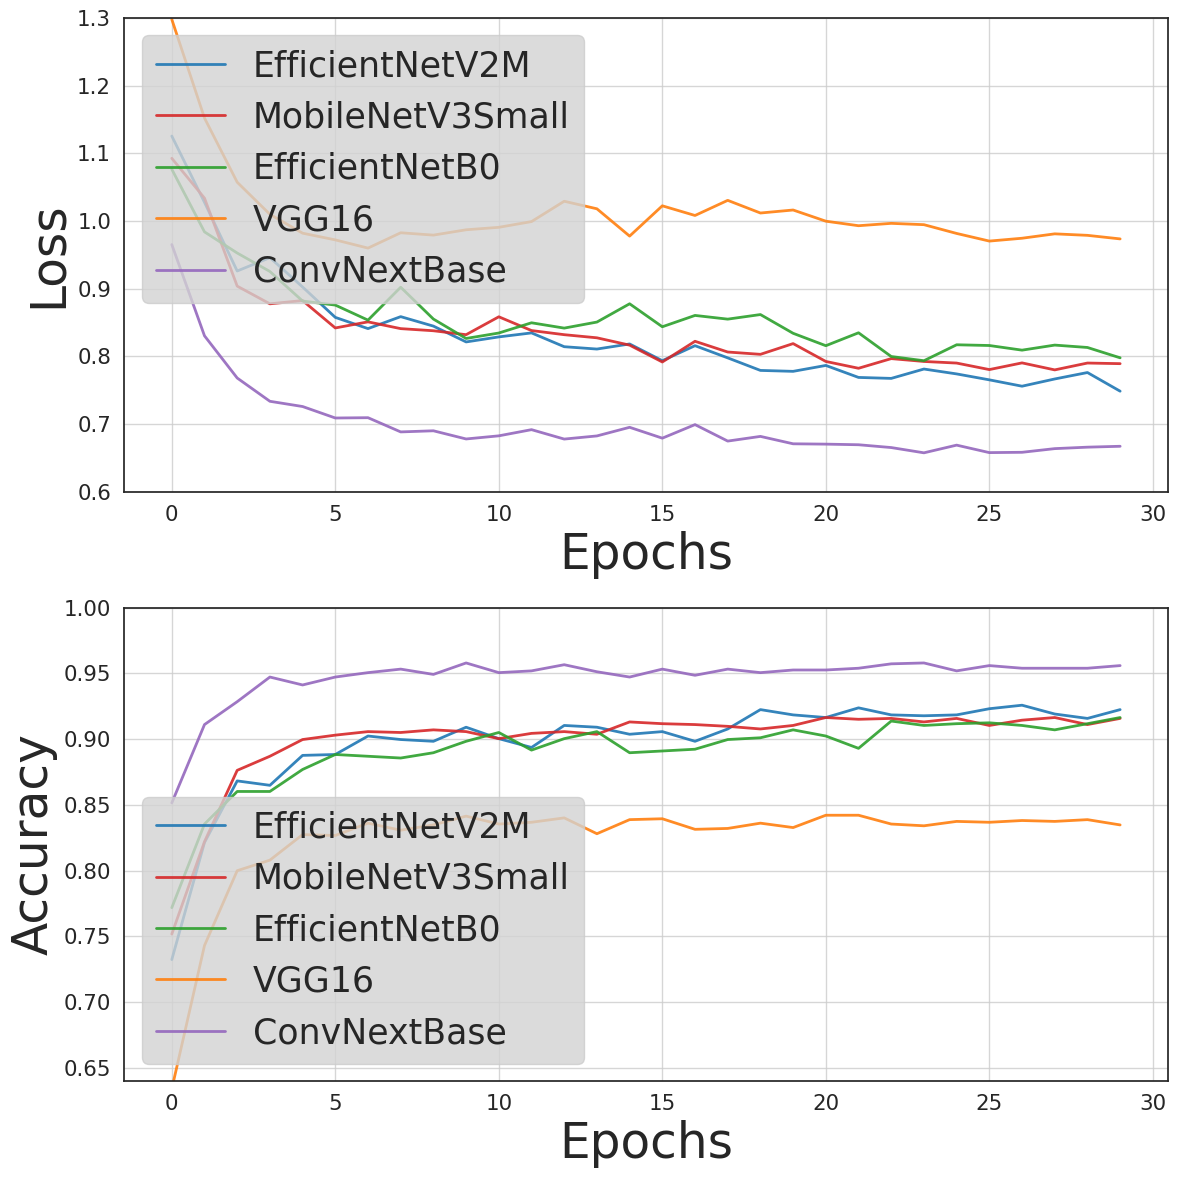

In [ ]:
import matplotlib.pyplot as plt

# Create figures and subplots for Loss and Accuracy.
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12,12))

# Define colors
colors = ['#1f77b4', '#d62728', '#2ca02c', '#ff7f0e', '#9467bd']
fig.patch.set_facecolor('white')  # Figure background is white
ax1.set_facecolor('white')
ax2.set_facecolor('white')

# Plot Loss
ax1.plot(tl_history_eff['val_loss'], label='EfficientNetV2M', color=colors[0], linestyle='-', linewidth=2, alpha=0.9)
ax1.plot(tl_history_mobile['val_loss'], label='MobileNetV3Small', color=colors[1], linestyle='-', linewidth=2, alpha=0.9)
ax1.plot(tl_history_effb0['val_loss'], label='EfficientNetB0', color=colors[2], linestyle='-', linewidth=2, alpha=0.9)
ax1.plot(tl_history_VGG['val_loss'], label='VGG16', color=colors[3], linestyle='-', linewidth=2, alpha=0.9)
ax1.plot(tl_history_ConvNext['val_loss'], label='ConvNextBase', color=colors[4], linestyle='-', linewidth=2, alpha=0.9)
ax1.set_xlabel('Epochs', fontsize=35)
ax1.set_ylabel('Loss', fontsize=35)
ax1.set_ylim(0.6, 1.3)
ax1.legend(loc='upper left', fontsize=25,facecolor="lightgrey")
ax1.grid(alpha=0.8)

# Plot Accuracy
ax2.plot(tl_history_eff['val_accuracy'], label='EfficientNetV2M', color=colors[0], linestyle='-', linewidth=2, alpha=0.9)
ax2.plot(tl_history_mobile['val_accuracy'], label='MobileNetV3Small', color=colors[1], linestyle='-', linewidth=2, alpha=0.9)
ax2.plot(tl_history_effb0['val_accuracy'], label='EfficientNetB0', color=colors[2], linestyle='-', linewidth=2, alpha=0.9)
ax2.plot(tl_history_VGG['val_accuracy'], label='VGG16', color=colors[3], linestyle='-', linewidth=2, alpha=0.9)
ax2.plot(tl_history_ConvNext['val_accuracy'], label='ConvNextBase', color=colors[4], linestyle='-', linewidth=2, alpha=0.9)
ax2.set_xlabel('Epochs', fontsize=35)
ax2.set_ylabel('Accuracy', fontsize=35)
ax2.set_ylim(0.64, 1.0)
ax2.legend(loc='lower left', fontsize=25,facecolor="lightgrey")
ax2.grid(alpha=0.8)

# Adjust the layout to prevent overlaps
plt.tight_layout()

# plot the graphic
plt.show()
